## Adjoint PDEs based on the example of BS PDE
This notebook also includes the finite adjoint of the non-linear PDE satisfied by an American option. 

22 May 2021

**Questions:** 
1. What is a good tolerance for np.isclose in the complex extension of the maximum and in the np.heaviside? 10e-16?

**To Do:**
1. Use checkpointing to reduce storage requirement (check whether I can then set N=100,000 and J=1,000)
2. Include $K$ as an argument of the fde 
3. create a testing environment to test different payoffs for the bumping/ complex variable trick/ forward mode and reverse mode. 


**Takeaways**:
1. There is no discretization error between the forward and the reverse mode. If there was a discretization error, the error would increase the finer I choose the grid. 
2. The computation of Greeks of American options uses the discontinuous heaviside function. Thus, rounding errors can have relevant impact. My solution is to implement a version of the heaviside function that checks whether the input of the heaviside function is zero within machine precision. Note that the numpy function heaviside checks if the input value is actually zero.
3. Bumping and complex variable trick can vary significantly for discontinuous payoffs. In particular, for a call option close to maturity, bumping results in a delta of ca. 0.5, while the complex variable trick depends on how we define the complex maximum function for the case in which the real parts of the arguments are equal (it would be 1 using our implementation of the maximum function). 
4. Divide and conquer. Divide task to mini-functions when possible (see the initialization of B). In this manner, I can detect errors easier when verifying the forward and reverse mode. 

In [61]:
import numpy as np
from matplotlib import pyplot as plt

### Auxiliary functions (general)

In [62]:
def maximum(arg1: np.array, arg2, is_complex: bool) -> np.array:
    """
    Elementwise maximum of two numpy arrays or of a numpy array with an integer.
    Defines the analytic extension of the maximum function in the complex case.
    If the entries are complex, return the entry with the biggest real part.
    If the real parts are equal, return the entry of the first argument. 
    """
    if is_complex:
        res = []
        if type(arg2) == np.ndarray:
            assert arg1.shape == arg2.shape
            #assert (np.iscomplex(x) and np.iscomplex(y))            
            for el1, el2 in zip(arg1, arg2):
                if el1.real >= el2.real or np.isclose(el1.real,0,atol=1e-16):
                    res.append(el1)
                else:
                    res.append(el2)
        else:
            # arg2 is integer
            assert type(arg2) == int
            for el in arg1:
                if el.real >= arg2:
                    res.append(el)
                else:
                    res.append(arg2)
        return np.array(res)
    else: 
        return np.maximum(arg1, arg2)

In [63]:
def check_forward_reverse_mode_identity(diff_u_list=[], u_bar_list=[], diff_A_list=[], A_bar_list = [],
                                       diff_v_list =[], v_bar_list=[], diff_B_list=[], B_bar_list = []):
    # diff_u_list, u_bar_list is a list of input np arrays
    # diff_A_list, A_bar_list is a list of input nd arrays representing the input matrices 
    # diff_v_list, v_bar_list is a list of output np arrays
    # diff_B_list, B_bar_list is a list of output nd arrays representing the output matrices 
    # to do: assert that the dimension of u_list and u_bar_list as well as A_list and A_bar_list is the same
    sum_lhs = 0
    for diff_u, u_bar in zip(diff_u_list, u_bar_list):
        sum_lhs += np.dot(u_bar, diff_u)
    for diff_A, A_bar in zip(diff_A_list, A_bar_list):
        sum_lhs += np.trace(A_bar.transpose() @ diff_A)
    sum_rhs = 0
    for diff_v, v_bar in zip(diff_v_list, v_bar_list):
        sum_rhs += np.dot(v_bar, diff_v)
    for diff_B, B_bar in zip(diff_B_list, B_bar_list):
        sum_rhs += np.trace(B_bar.transpose() @ diff_B)
    #print(sum_lhs, sum_rhs)
    err = abs(sum_lhs - sum_rhs)
    
    return err < 10e-15, err

In [64]:
def heaviside_close(x1, x2):
    closeCheck = np.isclose(x1, np.zeros_like(x1), atol=1e-16)
    heavisideBare = np.heaviside(x1, 0.0)
    zeroVal = np.where(closeCheck, x2, 0.0)-np.where(closeCheck, heavisideBare, np.zeros_like(heavisideBare))
    result = heavisideBare+zeroVal
    return result

**Stability condition:**
$$ \Delta t \leq \Delta S^2 $$

In [79]:
# input parameters
S0 = 1
T = 1
N = 16 # number of time steps 
J = 4 # 2*J+1 is number of spatial steps
K = 1

def payoff(S: np.array, is_complex = False) -> np.array:
    return maximum(S-K, 0, is_complex) # includes complex extension of the maximum as well
#     return maximum(K-S, 0, is_complex)
#     return S
    
def diff_payoff(S: np.array) -> np.array:
    return np.heaviside(S-K, 1)
#     return -np.heaviside(K-S, 1) 
#     return np.ones(S.shape)

delta_S = S0/J
delta_t = T/N
assert(delta_t <= delta_S**2), "No stability of the finite difference scheme"

### Auxiliary functions (specific)

In [80]:
def B_construction(S, sigma, r):
    #diff = delta_t / delta_S 
    diff = J/ N # numeridally more stable
    #diff2 = delta_t / delta_S**2
    diff2 = J**2/N
    a = S**2 * sigma**2 * diff2 / 2
    b = S * r * diff / 2
    low = a[1:] - b[1:]
    low[-1] = - r * S[-1] * diff
    centre = 1 - r*delta_t - 2*a
    centre[-1] = 1 - r * delta_t + r * S[-1] * diff 
    up  = a[:-1] + b[:-1]
    B = np.diag(low, -1) + np.diag(centre, 0) + np.diag(up, 1)
    return B

def diff_B_construction(S, sigma, r, diff_S, diff_sigma, diff_r):
    #diff = delta_t / delta_S
    diff = J/ N
    #diff2 = delta_t / delta_S**2
    diff2 = J**2/N
    a = S**2 * (sigma * diff_sigma * diff2) + S * diff_S * (sigma**2 * diff2)
    b = S * diff_r * diff / 2 + diff_S * r * diff / 2
    low = a[1:] - b[1:]
    low[-1] = - diff_r * S[-1] * diff - r * diff_S[-1] * diff
    centre = -diff_r * delta_t - 2*a
    centre[-1] = - diff_r * delta_t + diff_r * S[-1] * diff + r * diff_S[-1] * diff
    up = a[:-1] + b[:-1]
    diff_B = np.diag(low, -1) + np.diag(centre, 0) + np.diag(up, 1)
    return diff_B

def B_construction_reverse(B_bar, S_bar, S, sigma, r):
    d = 2*J+1
    diff = J/ N # numerically more stable
    #diff = delta_t/delta_S
    diff2 = J**2/N
    #diff2 = delta_t/delta_S**2
    sigma_bar = 0
    r_bar = (-delta_t + diff * S[-1]) * B_bar[-1][-1] - S[-1] * diff * B_bar[-1][-2] 
    S_bar[-1] = S_bar[-1] + r * diff * (B_bar[-1][-1] - B_bar[-1][-2])
    for j in reversed(range(d-1)):
        if j == 0:
            # B_bar[j-1][j] does not count
            a_bar = - 2 * B_bar[j][j] + B_bar[j][j+1]
            b_bar = B_bar[j][j+1]
        else:
            a_bar = B_bar[j][j-1] - 2 * B_bar[j][j] + B_bar[j][j+1]
            b_bar = - B_bar[j][j-1] + B_bar[j][j+1]
        sigma_bar = sigma_bar + sigma * S[j]**2 * diff2 * a_bar
        S_bar[j] = S_bar[j] + sigma**2 * S[j] * diff2 * a_bar + r/2 * diff * b_bar
        r_bar = r_bar + S[j]/2 * diff * b_bar - delta_t * B_bar[j][j]
    return S_bar, sigma_bar, r_bar

### BS PDE

In [81]:
# forward pass
def bs_pde_auxiliary(f, B, american = False, is_complex = False):
    u = np.copy(f)
    for n in reversed(range(N)):
        u = np.dot(B, u)
        u_copy = np.copy(u)
        if american: 
            u = maximum(u, f, is_complex)
    qoi = u[J]
    return qoi

def bs_pde(S0, sigma, r, american = False, is_complex = False):
    S = np.array([S0 + j*delta_S for j in range(-J, J+1)])
    B = B_construction(S, sigma, r)
    f = payoff(S, is_complex)
    return bs_pde_auxiliary(f, B, american, is_complex)

def bs_pde_auxiliary_f(f, B, american = False):
    u = np.copy(f)
    u_all_list = [u]; u_hat_all_list = []
    for n in reversed(range(N)):
        u = np.dot(B, u)
        if american:
            u_hat_all_list.append(u)
            u = maximum(u, f, is_complex = False)
            #print("u_hat:", u_hat_all_list[-1])
        u_all_list.append(u)
        #print("u:", u_all_list[-1])
    qoi = u[J]
    return list(reversed(u_all_list)), list(reversed(u_hat_all_list))

def bs_pde_f(S0, sigma, r, american = False):
    S = np.array([S0 + j*delta_S for j in range(-J, J+1)])
    B = B_construction(S, sigma, r)
    f = payoff(S)
    u_all_list, u_hat_all_list = bs_pde_auxiliary_f(f, B, american)
    return S, B, u_all_list, u_hat_all_list

In [82]:
# forward mode
def bs_pde_auxiliary_forward(f, B, diff_f, diff_B):
    diff_b_all_list = []
    diff_u = diff_f
    u = np.copy(f)
    for n in reversed(range(N)):
        diff_b = np.dot(diff_B, u)
        diff_u = np.dot(B, diff_u) + diff_b
        u = np.dot(B, u)
        diff_b_all_list.append(diff_b)
    diff_qoi = diff_u[J]
    qoi = u[J]
    return qoi, diff_qoi, list(reversed(diff_b_all_list)) #reverse diff_b list to be forward in time


def bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r, american = False):
    diff_S = diff_S0 * np.ones(2*J + 1)
    S = np.array([S0 + j*delta_S for j in range(-J, J+1)])
    diff_u = diff_payoff(S) * diff_S
    u = payoff(S)
    diff_B = diff_B_construction(S, sigma, r, diff_S, diff_sigma, diff_r)
    B = B_construction(S, sigma, r)
    for n in reversed(range(N)):
        diff_u = np.dot(B, diff_u) + np.dot(diff_B, u)
        u = np.dot(B, u)
        if american: 
#             holding  = heaviside_close(u-payoff(S), 1)
            holding  = np.heaviside(u-payoff(S), 1)
            print(holding)
            diff_u = diff_u * holding + diff_payoff(S) * diff_S * (1-holding) 
            u = maximum(u, payoff(S), is_complex = False)
    diff_qoi = diff_u[J]
    qoi = u[J]
    return qoi, diff_qoi

In [83]:
# reverse mode
def bs_pde_auxiliary_b(B, qoi_bar=1):
    d = 2*J+1
    u_bar = np.zeros(d)
    u_bar[J] = qoi_bar
    b_bar_all_list = []
    B_transpose = B.transpose()
    for n in range(N):
        b_bar = u_bar 
        u_bar = np.dot(B_transpose, u_bar)
        b_bar_all_list.append(b_bar)
    f_bar = u_bar
    return f_bar, b_bar_all_list

def bs_pde_auxiliary_reverse(B, qoi_bar=1):
    # forward pass
    # u_all_list = bs_pde_auxiliary_f(f, B)
    # backward pass 
    f_bar, b_bar_all_list = bs_pde_auxiliary_b(B,qoi_bar=1)
    return f_bar, b_bar_all_list
    

def bs_pde_b(S, sigma, r, B, u_all_list, u_hat_all_list = [], qoi_bar=1, american = False):
    assert(not (american is True and not u_hat_all_list)), "American option with empty u_hat list"
    d = 2*J+1
    S_bar = np.zeros(d); B_bar = np.zeros((d,d))
    u_bar = np.zeros(d)
    u_bar[J] = qoi_bar
    B_transpose = B.transpose()
    for n in range(N):              
        if american: 
            holding = heaviside_close(u_hat_all_list[n] - payoff(S), 1)
            #print("holding: ", holding)
            u_hat_bar = u_bar * holding
            S_bar = S_bar + diff_payoff(S) * u_bar * (1 - holding)
            B_bar = B_bar + np.outer(u_hat_bar, u_all_list[n+1])
            u_bar = np.dot(B_transpose, u_hat_bar)
        else: 
            B_bar = B_bar + np.outer(u_bar, u_all_list[n+1])
            u_bar = np.dot(B_transpose, u_bar)
    S_bar, sigma_bar, r_bar = B_construction_reverse(B_bar, S_bar, S, sigma, r)
    S_bar = S_bar + diff_payoff(S) * u_bar # elementwise multiplication
    S0_bar = sum(S_bar)
    return S0_bar, sigma_bar, r_bar

def bs_pde_reverse(S0, sigma, r, qoi_bar=1, american = False):
    #forward pass 
    S, B, u_all_list, u_hat_all_list = bs_pde_f(S0, sigma, r, american)
    #backward pass
    S0_bar, sigma_bar, r_bar = bs_pde_b(S, sigma, r, B, u_all_list, u_hat_all_list, qoi_bar, american)
    return S0_bar, sigma_bar, r_bar

### Adjoint BS PDE

In [84]:
# forward pass 
def adjoint_bs_pde_auxiliary(f, B):
    p = np.zeros(2*J + 1)
    p[J] = 1
    B_transpose = B.transpose()
    for n in range(N):
        p = np.dot(B_transpose, p)
    qoi = np.dot(p, f)
    return qoi

def adjoint_bs_pde(S0, sigma, r, is_complex = False):
    S = np.array([S0 + j*delta_S for j in range(-J, J+1)])
    B = B_construction(S, sigma, r)
    f = payoff(S, is_complex)
    return adjoint_bs_pde_auxiliary(f,B)


def adjoint_bs_pde_auxiliary_f(f, B):
    p = np.zeros(2*J + 1); p[J] = 1
    p_all_list = [p]
    B_transpose = B.transpose()
    for n in range(N):
        p = np.dot(B_transpose, p)
        p_all_list.append(p)
    qoi = np.dot(p, f)
    return p_all_list


def adjoint_bs_pde_f(S0, sigma, r):
    S = np.array([S0 + j*delta_S for j in range(-J, J+1)])
    B = B_construction(S, sigma, r)
    f = payoff(S)
    p_all_list = adjoint_bs_pde_auxiliary_f(f,B)
    return S, B, p_all_list

In [85]:
# forward mode
def adjoint_bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r):
    diff_p = np.zeros(2*J + 1)
    p = np.zeros(2*J + 1); p[J] = 1
    diff_S = diff_S0 * np.ones(2*J + 1)
    S = np.array([S0 + j*delta_S for j in range(-J, J+1)])
    diff_B_transpose = diff_B_construction(S, sigma, r, diff_S, diff_sigma, diff_r).transpose()
    B_transpose = B_construction(S, sigma, r).transpose()
    for n in range(N):
        diff_p = np.dot(B_transpose, diff_p) + np.dot(diff_B_transpose, p)
        p = np.dot(B_transpose, p)
    diff_f = diff_payoff(S)*diff_S
    f = payoff(S)
    diff_qoi = np.dot(p, diff_f) + np.dot(diff_p, f)
    qoi = np.dot(p, f)
    return qoi, diff_qoi

In [86]:
# reverse mode
def adjoint_bs_pde_b(S, sigma, r, B, p_all_list, qoi_bar):
    d = 2*J+1
    B_transpose_bar = np.zeros((d,d))
    S_bar = p_all_list[-1] * diff_payoff(S) * qoi_bar # first/second multiplication is elementwise/scalar
    p_bar = payoff(S) * qoi_bar
    for n in reversed(range(N)):
        B_transpose_bar = B_transpose_bar + np.outer(p_bar, p_all_list[n])
        p_bar = np.dot(B, p_bar)
    B_bar = B_transpose_bar.transpose()
    S_bar, sigma_bar, r_bar = B_construction_reverse(B_bar, S_bar, S, sigma, r)
    S0_bar = sum(S_bar)
    return S0_bar, sigma_bar, r_bar
        

def adjoint_bs_pde_reverse(S0, sigma, r, qoi_bar=1):
    # forward pass
    S, B, p_all_list = adjoint_bs_pde_f(S0, sigma, r)
    # backward pass
    S0_bar, sigma_bar, r_bar = adjoint_bs_pde_b(S, sigma, r, B, p_all_list, qoi_bar)
    return S0_bar, sigma_bar, r_bar

### Validation

In [90]:
# testing parameters 
sigma = 0.1
r = 0.1

S = np.array([S0 + j*delta_S for j in range(-J, J+1)])
f = payoff(S)
B = B_construction(S, sigma, r)

In [91]:
# check adjoint PDE
value = bs_pde(S0, sigma, r)
value_adjoint = adjoint_bs_pde(S0, sigma, r)

# print("Black-Scholes PDE (backward in time):", value)
# print("Adjoint Black Scholes PDE (forward in time):", value_adjoint)
print("Difference of result between PDE and adjoint PDE: ", abs(value - value_adjoint))

value2 = bs_pde_auxiliary(f, B)
value2_adjoint = adjoint_bs_pde_auxiliary(f, B)

# print("Auxiliary Black-Scholes PDE 2 (backward in time):", value2)
# print("Adjoint Auxiliary Black Scholes PDE 2(forward in time):", value2_adjoint)
print("Difference of result between auxiliary BS PDE and adjoint auxiliary PDE: ", abs(value2 - value2_adjoint))

Difference of result between PDE and adjoint PDE:  2.7755575615628914e-17
Difference of result between auxiliary BS PDE and adjoint auxiliary PDE:  2.7755575615628914e-17


In [92]:
diff_S0 = 1
diff_sigma = 0
diff_r = 0
diff_f = np.ones(2*J+1)
diff_B = np.zeros((2*J+1,2*J+1))

# bumping 
epsilon = 10e-7
S0_plus = S0 + epsilon
S0_minus = S0 - epsilon 
delta_bumping = (bs_pde(S0_plus, sigma, r) - bs_pde(S0_minus, sigma, r))/(2*epsilon)
delta_american_bumping  = (bs_pde(S0_plus, sigma, r, True) - bs_pde(S0_minus, sigma, r, True))/(2*epsilon)
f_plus = f + epsilon
f_minus = f - epsilon
delta2_bumping = (bs_pde_auxiliary(f_plus, B) - bs_pde_auxiliary(f_minus, B))/(2*epsilon)

# complex variable trick
epsilon = 10e-20
S0_epsilon = S0 + epsilon * 1j
delta_complex_trick = bs_pde(S0_epsilon, sigma, r, american=False, is_complex=True).imag / epsilon
delta_american_complex_trick = bs_pde(S0_epsilon, sigma, r, american=True, is_complex=True).imag / epsilon
f_epsilon = f + epsilon * 1j
delta2_complex_trick = bs_pde_auxiliary(f_epsilon,B).imag / epsilon

print("BS PDE: difference between the complex variable trick and bumping is: ", abs(delta_bumping-delta_complex_trick))
print("BS PDE (auxiliary): difference between the complex variable trick and bumping is: ", abs(delta2_bumping-delta2_complex_trick))
print("American option: difference between the complex variable trick and bumping is:", abs(delta_american_bumping - delta_american_complex_trick))

#check forward mode
value, delta = bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r)
value_american, delta_american = bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r, True)
value2, delta2, diff_b = bs_pde_auxiliary_forward(f, B, diff_f, diff_B)
value_adjoint, delta_adjoint = adjoint_bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r)

print("BS PDE: difference of delta between the forward mode and complex variable trick is:", abs(delta_complex_trick - delta))
print("BS PDE (auxiliary): diff. of delta between the forward mode and complex variable trick is:", abs(delta2_complex_trick - delta2))
print("American option: difference of delta between the forward mode and complex variable trick is:", abs(delta_american - delta_american_complex_trick))
print("Adjoint BS PDE: difference of delta between forward mode BS PDE and ajoint BS PDE is:", abs(delta_adjoint-delta))

BS PDE: difference between the complex variable trick and bumping is:  0.3739593799006036
BS PDE (auxiliary): difference between the complex variable trick and bumping is:  7.518097255854173e-12
American option: difference between the complex variable trick and bumping is: 0.3739593799006036
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
BS PDE: difference of delta between the forward mode and complex variable trick is: 4.440892098500626e-16
BS PDE (auxiliary): diff. of delta between the forward mode and complex variable trick is: 1.1102230246251565e-16
American option: differ

In [41]:
diff_S0 = 0
diff_sigma = 0
diff_r = 1

# bumping 
epsilon = 10e-7
r_plus = r + epsilon
r_minus = r - epsilon 
rho_bumping = (bs_pde(S0, sigma, r_plus) - bs_pde(S0, sigma, r_minus))/(2*epsilon)
rho_american_bumping  = (bs_pde(S0, sigma, r_plus, True) - bs_pde(S0, sigma, r_minus, True))/(2*epsilon)

# complex variable trick
epsilon = 10e-20
r_epsilon = r + epsilon * 1j
rho_complex_trick = bs_pde(S0, sigma, r_epsilon).imag / epsilon
rho_american_complex_trick = bs_pde(S0, sigma, r_epsilon, True).imag / epsilon

print("BS PDE: difference between the complex variable trick and bumping is: ", abs(rho_bumping-rho_complex_trick))
print("American option: difference between the complex variable trick and bumping is:", abs(rho_american_bumping - rho_american_complex_trick))

#check forward mode
value, rho = bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r)
value_american, rho_american = bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r, True)
value_adjoint, rho_adjoint = adjoint_bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r)

print("BS PDE: difference of delta between the forward mode and complex variable trick is:", abs(rho_complex_trick - rho))
print("American option: difference between the complex variable trick and bumping is", abs(rho_american_complex_trick - rho_american))
print("Adjoint BS PDE: difference between forward mode BS PDE and ajoint BS PDE is:", abs(delta_adjoint-delta))

BS PDE: difference between the complex variable trick and bumping is:  2.9917179844574093e-12
American option: difference between the complex variable trick and bumping is: 1.356414980335785e-12
BS PDE: difference of delta between the forward mode and complex variable trick is: 5.551115123125783e-17
American option: difference between the complex variable trick and bumping is 1.6653345369377348e-16
Adjoint BS PDE: difference between forward mode BS PDE and ajoint BS PDE is: 4.440892098500626e-16


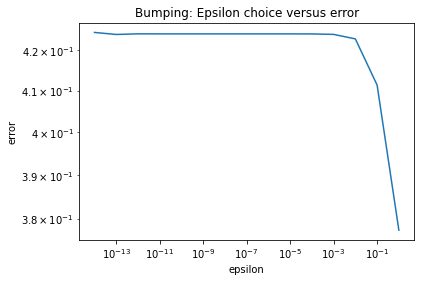

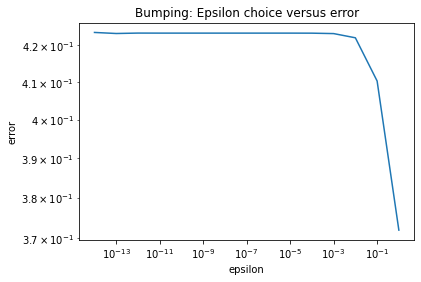

In [42]:
#check bumping
def check_bumping_bs_pde(correct, american = False):
    x = []
    y = []
    for i in range(15):
        epsilon = 10**(-i)
        S0_plus = S0 + epsilon
        S0_minus = S0 - epsilon 
        delta_bumping = (bs_pde(S0_plus, sigma, r, american) - bs_pde(S0_minus, sigma, r, american))/(2*epsilon)
        err = abs(correct-delta_bumping)
        x.append(epsilon), y.append(err)
    plt.plot(x,y)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("epsilon")
    plt.ylabel("error")
    plt.title("Bumping: Epsilon choice versus error")
    plt.show()

check_bumping_bs_pde(delta_complex_trick)
check_bumping_bs_pde(delta_american_complex_trick, True)

In [58]:
#check reverse mode
# qoi_bar = 1
qoi_bar = np.random.randn()
# diff_S0, diff_sigma, diff_r = 0, 0, 1
diff_S0, diff_sigma, diff_r = 3 * np.random.randn(3)

# BS PDE (including American)
# forward mode
qoi, diff_qoi = bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r)
qoi_american, diff_qoi_american = bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r, american = True)
qoi_adjoint, diff_qoi_adjoint = adjoint_bs_pde_forward(S0, sigma, r, diff_S0, diff_sigma, diff_r)
# reverse mode
u_bar = bs_pde_reverse(S0, sigma, r, qoi_bar)
u_american_bar = bs_pde_reverse(S0, sigma, r, qoi_bar, american = True)
u_adjoint_bar = adjoint_bs_pde_reverse(S0, sigma, r, qoi_bar)

# BS PDE auxiliary 
diff_f = diff_payoff(S) * diff_S0
diff_S = diff_S0 * np.ones(2*J+1)
diff_B = diff_B_construction(S, sigma, r, diff_S, diff_sigma, diff_r)
# forward mode
qoi2, diff_qoi2, diff_b = bs_pde_auxiliary_forward(f, B, diff_f, diff_B)
# reverse mode
f_bar, b_bar = bs_pde_auxiliary_reverse(B, qoi_bar)
assert len(b_bar) == len(diff_b)
theta_bar = np.dot(f_bar, diff_f) + sum([np.dot(b_bar[i], diff_b[i]) for i in range(len(diff_b))])

diff_u = diff_S0, diff_sigma, diff_r
b, err = check_forward_reverse_mode_identity([diff_u], [u_bar], [], [], [diff_qoi], [qoi_bar], [], [])
b_american, err_american = check_forward_reverse_mode_identity([diff_u], [u_american_bar], [], [], [diff_qoi_american], [qoi_bar], [], [])
b_adjoint, err_adjoint = check_forward_reverse_mode_identity([diff_u], [u_adjoint_bar], [], [], [diff_qoi_adjoint], [qoi_bar], [], [])

print("BS PDE: the forward/ reverse mode identiy holds:", b, "the error is:", err)
print("BS PDE (auxiliary): diff. between the forward mode of the BS PDE and the result of the auxiliary BS PDE is:", 
      abs(theta_bar - diff_qoi))
print("American option: the forward/ reverse mode identity holds:", b_american, "the error is", err_american)
print("Adjoint BS PDE: the forward/ reverse mode identity holds:", b_adjoint, "the error is", err_adjoint)

BS PDE: the forward/ reverse mode identiy holds: True the error is: 2.636779683484747e-16
BS PDE (auxiliary): diff. between the forward mode of the BS PDE and the result of the auxiliary BS PDE is: 9.71445146547012e-17
American option: the forward/ reverse mode identity holds: True the error is 1.1102230246251565e-16
Adjoint BS PDE: the forward/ reverse mode identity holds: True the error is 8.326672684688674e-17
